<a href="https://colab.research.google.com/github/farshidbalan/MachineLearning/blob/master/Using_XGBoost_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://www.datacamp.com/community/tutorials/xgboost-in-python

## What is Boosting?

Boosting is a sequential technique which works on the principle of an ensemble. 

*  It combines a set of weak learners and delivers improved prediction accuracy.
*  At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1
*  The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher

#### what is a weak learner?

a weak learner is one which is slightly better than random guessing. For example, a decision tree whose predictions are slightly better than 50%. 

![alt text](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1528107577/output_1_0_ilvuyr.png)


 __Box 1__. The first classifier (usually a decision stump) creates a vertical line (split) at D1. It says anything to the left of D1 is + and anything to the right of D1 is - (However, this classifier misclassifies three + points.)
 
__Box 2__. The second classifier gives more weight to the three + misclassified points (see the bigger size of +) and creates a vertical line at D2. Again it says, anything to the right of D2 is - and left is +. Still, it makes mistakes by incorrectly classifying three - points.

__Box3__. the third classifier gives more weight to the three - misclassified points and creates a horizontal line at D3. Still, this classifier fails to classify the points (in the circles) correctly.

__Box4__.  This is a weighted combination of the weak classifiers (Box 1,2 and 3). As you can see, it does a good job at classifying all the points correctly.


#### Basic Idea

1. building a weak model, 
2. making conclusions about the various feature importance and parameters,
3. using those conclusions to build a new, stronger model 
4. capitalize on the misclassification error of the previous model and try to reduce it.



## XGBoost's hyperparameters

* learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
* max_depth: determines how deeply each tree is allowed to grow during any boosting round.
* subsample: percentage of samples used per tree. Low value can lead to underfitting.
* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
* n_estimators: number of trees you want to build.
* objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.
* XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.
* gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
* alpha: L1 regularization on leaf weights. A large value leads to more regularization.
* lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

## Residential Home Price in Boston

In this tutorial, we will be using XGBoost to solve a regression problem. The dataset is taken from the UCI Machine Learning Repository and is also present in sklearn's datasets module. It has 14 explanatory variables describing various aspects of residential homes in Boston, the challenge is to predict the median value of owner-occupied homes per $1000s.

__Source__: https://archive.ics.uci.edu/ml/machine-learning-databases/housing/ 

In [44]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
boston = load_boston()
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [4]:
print(boston.feature_names)


['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [8]:
data = pd.DataFrame(boston.data)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [0]:
data.columns = boston.feature_names

In [11]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [12]:
# add the price column to the data 

data['PRICE'] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [15]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Remark


*   If you plan to use XGBoost on a dataset which has categorical features you may want to consider applying some encoding (like one-hot encoding) to such features before training the model.
*    Also, if you have some missing values such as NA in the dataset you may or may not do a separate treatment for them, because XGBoost is capable of handling missing values internally. You can check out this link if you wish to know more on this.



In [0]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]

### Remark

Now you will convert the dataset into an optimized data structure called __Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains__.

In [30]:
data_matrix = xgb.DMatrix(data=X, label=y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)


In [32]:
xg_ref = xgb.XGBRFRegressor(objective='reg:squarederror', colsample_bytree=.3, learning_rate=.1, max_depth=5, alpha=10, n_estimators=10)
xg_ref.fit(X_train, y_train)
preds = xg_ref.predict(X_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [33]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse}")

RMSE: 22.270992107008297


### k-fold Cross Validation using XGBoost
In order to build more robust models, it is common to do a __k-fold__ cross validation where all the entries in the original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. XGBoost supports k-fold cross validation via the __cv()__ method. All you have to do is specify the __nfolds__ parameter, which is the number of cross validation sets you want to build. Also, it supports many other parameters (check out this link) like:

* num_boost_round: denotes the number of trees you build (analogous to n_estimators)
* metrics: tells the evaluation metrics to be watched during CV
* as_pandas: to return the results in a pandas DataFrame.
* early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
* seed: for reproducibility of results.

In [0]:
# create a hyper-parameter dictionary params which holds all the hyper-parameters and their values as key-value pairs 
params = {'objective':'reg:squarederror', 'colsample_bytree': .3, 'learning_rate': .1, 'max_depth': 5, 'alpha': 10,}

cv_results = xgb.cv(dtrain=data_matrix, 
                    params=params, 
                    nfold=3, 
                    num_boost_round=100, 
                    early_stopping_rounds=10, 
                    metrics='rmse',
                    as_pandas=True,
                    seed=123)

In [42]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.679234,0.025626,21.677613,0.050617
1,19.772293,0.016054,19.773320,0.020571
2,18.049563,0.058904,18.065856,0.082746
3,16.430113,0.013615,16.492199,0.020919
4,15.025977,0.062132,15.132644,0.073104


In [43]:
cv_results['test-rmse-mean'].tail()

95    3.618257
96    3.615773
97    3.614567
98    3.612084
99    3.611989
Name: test-rmse-mean, dtype: float64

### Visualize Boosting Trees and Feature Importance

You can also visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset. XGBoost has a __plot_tree()__ function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the __plot_tree()__ function along with the number of trees you want to plot using the num_trees argument.

In [0]:
xg_reg = xgb.train(params=params, dtrain=data_matrix, num_boost_round=10)

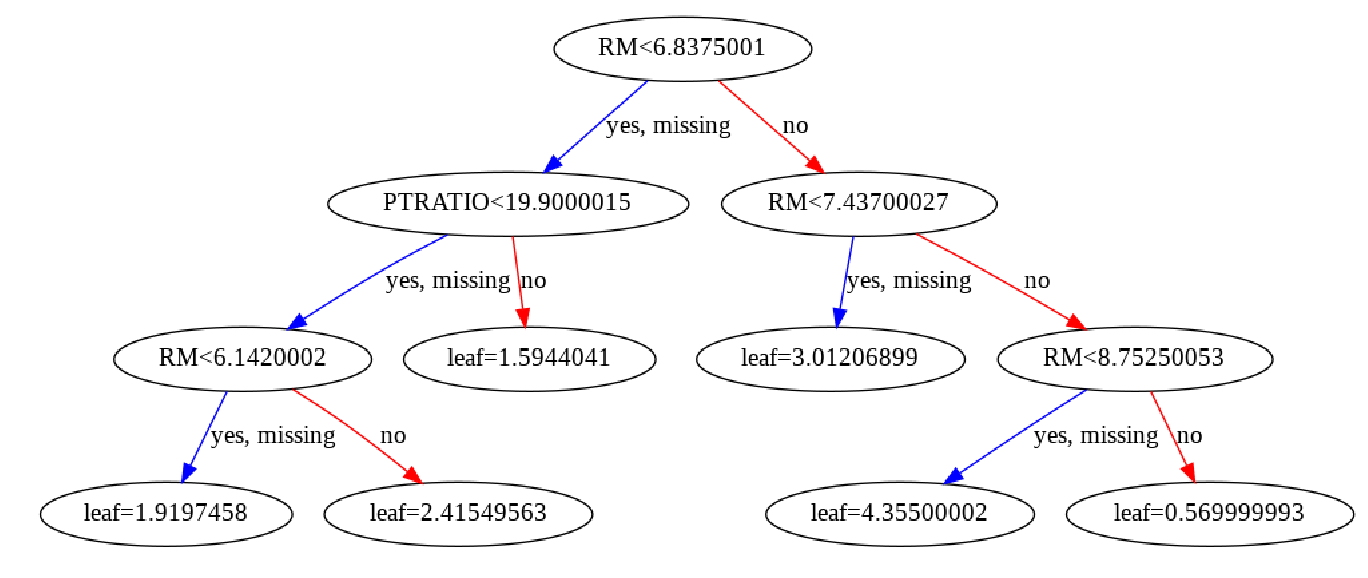

In [52]:
xgb.plot_tree(xg_reg, num_trees=0)
plt.rcParams['figure.figsize'] = [45, 10]
plt.show()

Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a __plot_importance()__ function that allows you to do exactly this.

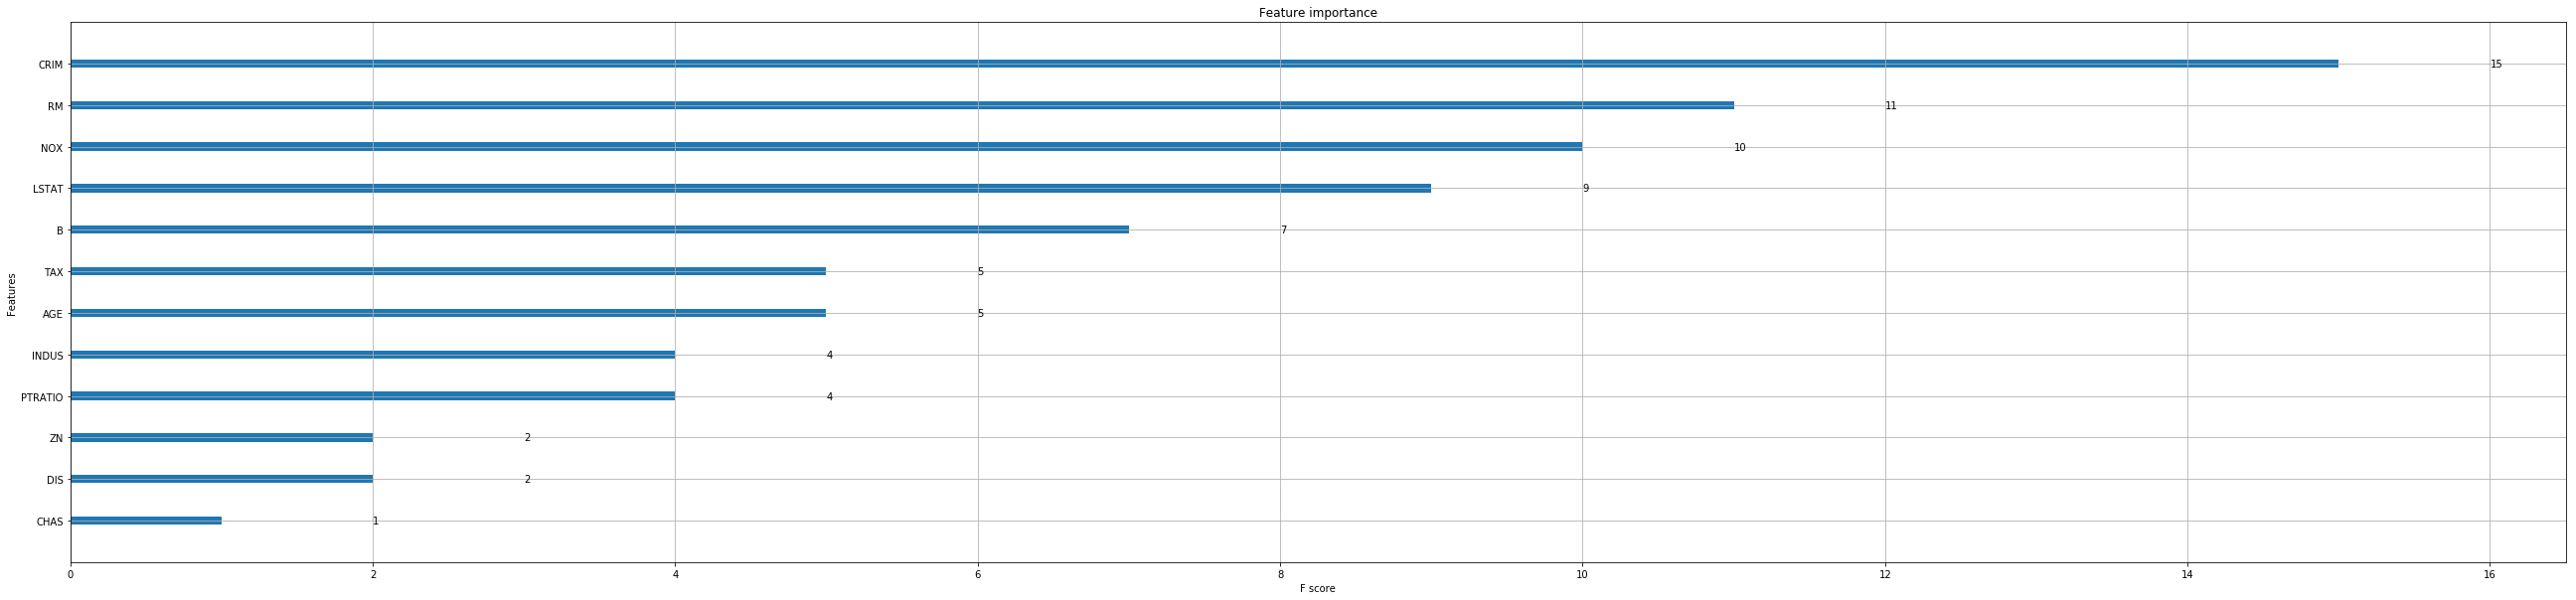

In [53]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()